# VR Track Jets

One last goal of the retraining campaign is to look at the VR track jet collection to see if the training from PFLow can be applied there, or if we should consider another VR dedicated training.

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Step 1: Compare the input distributions

Why is this important? It should also give us a feeling for whether *retraining* is necessary or not!

**Load in the data**

In [2]:
# VR: ttbar
mc = "mc16d"
jetCollection =  "VR"
physicsSample = "ttbar"

subDir = '{}_{}_{}'.format(mc, jetCollection, physicsSample)
dataDir = '../../data/'

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)
scale_tag = "_hybrid_5TeV_scale"

f_name = "{}/data_{}{}.hdf5".format(dataDir+subDir,dataTagTest,scale_tag)

f = h5py.File(f_name,"r")
X_VR_ttbar = f['X_test'][:]
y_VR_ttbar = f['y_test'][:]
ix_VR_ttbar = f['ix_test'][:]
f.close()

df_tag = '2mtest_15trks_sd0_rev'
jdf_VR_ttbar = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')

# Z'
physicsSample = "Zprime_1.5TeV"
subDir = '{}_{}_{}'.format(mc, jetCollection, physicsSample)

f_name = "{}/data_{}{}.hdf5".format(dataDir+subDir,dataTagTest,scale_tag)

f = h5py.File(f_name,"r")
X_VR_Zprime = f['X_test'][:]
y_VR_Zprime = f['y_test'][:]
ix_VR_Zprime = f['ix_test'][:]
f.close()

df_tag = '2mtest_15trks_sd0_rev'
jdf_VR_Zprime = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')


In [3]:
scale_tag

'_hybrid_5TeV_scale'

In [4]:
# PFlow: ttbar
jetCollection = "PFlow"
physicsSample = "ttbar"

subDir = '{}_{}_{}'.format(mc, jetCollection, physicsSample)

f_name = "{}/data_{}{}.hdf5".format(dataDir+subDir,dataTagTest,scale_tag)

f = h5py.File(f_name,"r")
X_PFlow_ttbar = f['X_test'][:]
y_PFlow_ttbar = f['y_test'][:]
ix_PFlow_ttbar = f['ix_test'][:]
f.close()

df_tag = '2mtest_15trks_sd0_rev'
jdf_PFlow_ttbar = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')

# Z'
physicsSample = "Zprime_1.5TeV"
subDir = '{}_{}_{}'.format(mc, jetCollection, physicsSample)

f_name = "{}/data_{}{}.hdf5".format(dataDir+subDir,dataTagTest,scale_tag)

f = h5py.File(f_name,"r")
X_PFlow_Zprime = f['X_test'][:]
y_PFlow_Zprime = f['y_test'][:]
ix_PFlow_Zprime = f['ix_test'][:]
f.close()

df_tag = '2mtest_15trks_sd0_rev'
jdf_PFlow_Zprime = pd.read_hdf('{}/{}/jet_{}.h5'.format(dataDir,subDir,df_tag), key='jet_df')


In [5]:
dataTagTrain = "5mtrain_15trks_{}".format(vStr)
subDir = 'mc16d_PFlow_hybrid_5TeV'
s_name = "{}/{}/scale_{}.json".format(dataDir,subDir,dataTagTrain)
with open(s_name, 'r') as sfile:
    d = json.load(sfile)

What do I want to compare? I want to  see if the distribuitons *changed* from the PFlow to the VR track jet collections.

In [6]:
trk_vars = strToList(vStr,'_')
trk_vars.remove('logNorm')
trk_vars.remove('norm')

logNormVars = trk_vars[-4:-2]
normVars = trk_vars[-4:]

In [7]:
xlabels = ['$s_{d0}$', '$s_{z0}$', 
           'PIX1 hits', 'IBL hits',
           'IBL shared hits', 'IBL split hits', 
           'shared pixel hits', 'split pixel hits',
           'shared SCT hits','$p_T^{frac}$','$\Delta R$',
           'pixel hits','SCT hits'
          ]

var_bins = [50,50,
            5,5,5,5,
            10,10,10,
            50,50,
            10,21]

var_ranges = [(-10,10),(-10,10),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (0,0.5), (0, .4),
              (-0.5,9.5),(-0.5,20.5)]

In [8]:
d

{'ptfrac': {'mean': -3.7198679447174072, 'sd': 1.6432801485061646},
 'dr': {'mean': -2.7787461280822754, 'sd': 1.1020185947418213},
 'nPixHits': {'mean': 4.066926956176758, 'sd': 0.8257577419281006},
 'nSCTHits': {'mean': 8.087814331054688, 'sd': 1.3968151807785034}}

ttbar


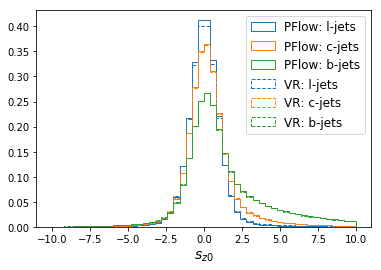

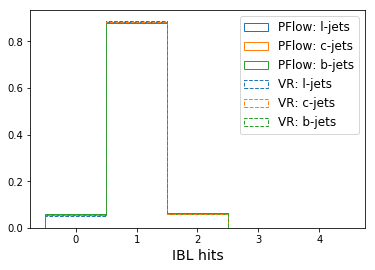

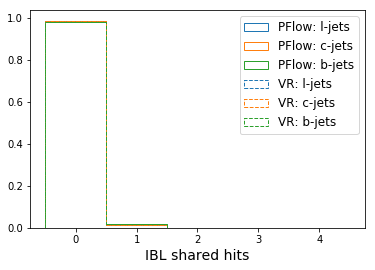

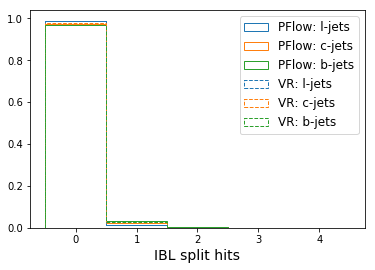

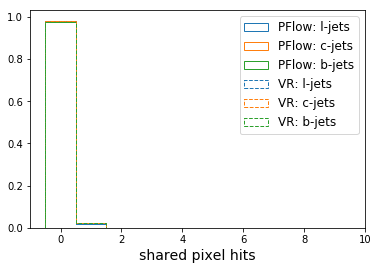

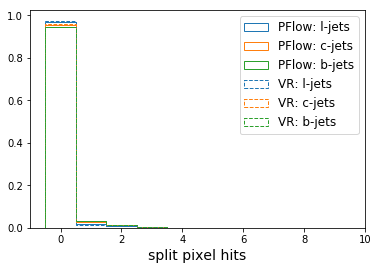

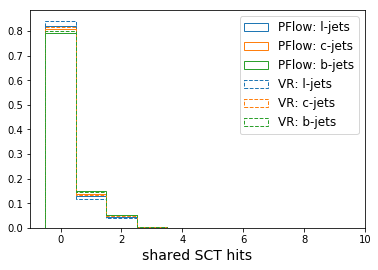

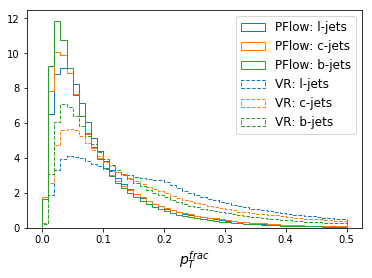

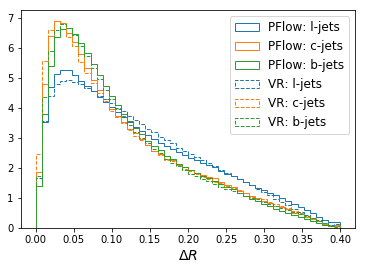

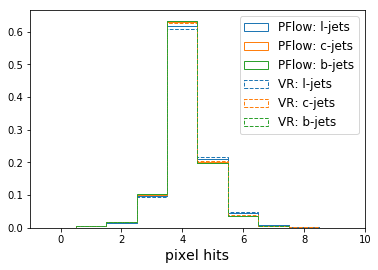

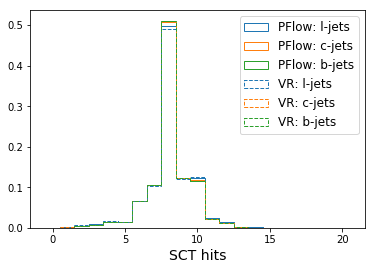

Zprime_1.5TeV


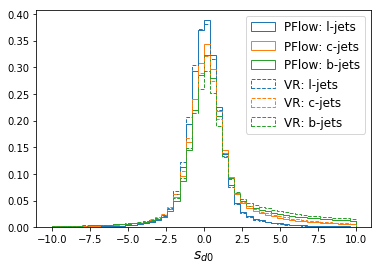

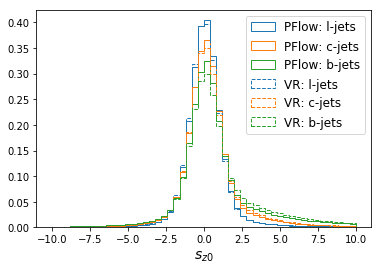

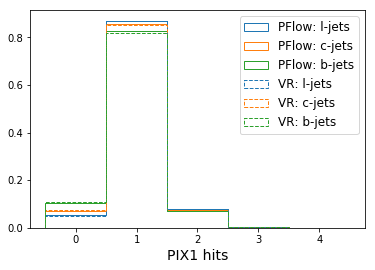

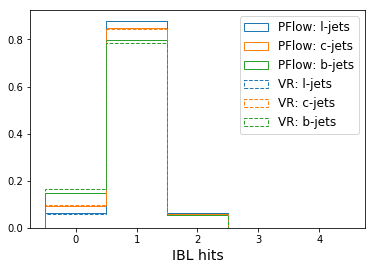

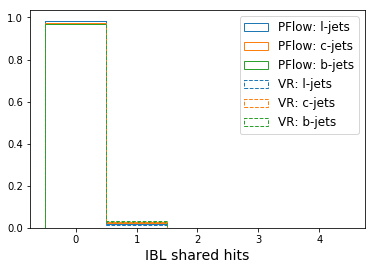

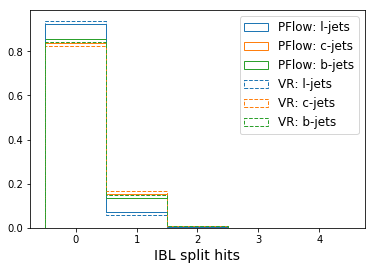

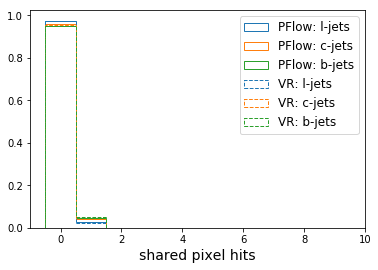

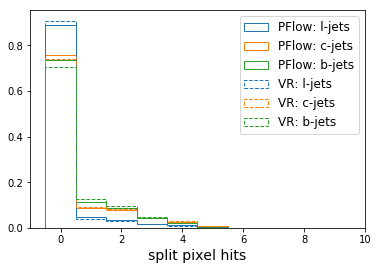

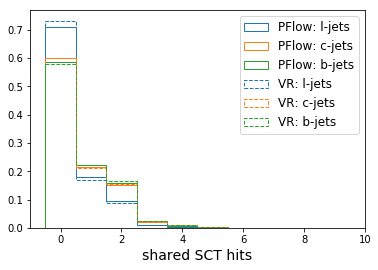

In [9]:
for i, (physicsSample, Xs, ys) in enumerate(zip(['ttbar','Zprime_1.5TeV'],
                                                [[X_PFlow_ttbar,X_VR_ttbar],[X_PFlow_Zprime,X_VR_Zprime]],
                                                [[y_PFlow_ttbar,y_VR_ttbar],[y_PFlow_Zprime,y_VR_Zprime]])):

    print(physicsSample)
    
    for X, y, jetCollection, l in zip(Xs, ys, ['PFlow','VR'], ['-','--']):

        # Get the mask since all of the truth labels are track level variables
        y_trks = np.ones_like(X[:,:,0])
        y_trks = y_trks * y.reshape(-1,1)

        # This mask selects the non-masked tracks in the jet
        mask = getTrkMask(X)
        y_trks = y_trks[mask]

        for j, (trk_var, xlabel, nBins, myRange) in enumerate(zip(trk_vars, xlabels,var_bins, var_ranges)):

            # Access the non-masked trks in the jet for this trk feature
            var = X[:,:,j][mask].copy()

            if trk_var in normVars:
                mu, sigma = d[trk_var]['mean'], d[trk_var]['sd']
                var = mu + sigma * var

            if trk_var in logNormVars:
                var = np.exp(var)

            idx = i * len(trk_vars) + j
            plt.figure(idx)

            for yi, flav in zip(range(3), ['l','c','b']):

                plt.hist(var[y_trks == yi],
                         range=myRange,bins=nBins,
                         histtype='step', density=True, 
                         color='C{}'.format(yi), linestyle=l,
                         label='{}: {}-jets'.format(jetCollection,flav))

            plt.legend(fontsize=12)  
            plt.xlabel(xlabel,fontsize=14)            
            plt.savefig('../../figures/mc16d_VR_{}/PFlow_cf/{}.pdf'.format(physicsSample,trk_var))

    plt.show()


Ok, just by looking at these distributions, the biggest difference is with the $\Delta R$ profile, it's much collimated for VR track-jets, with the biggest discrepancy w/r.t. PFlow showing up in the l-jets.


Also, it there are more discrepancies with jet collections with the Z' distributions than with the ttbar distributions. 

**Compare the VR and PFlow comparison**

ttbar
Zprime_1.5TeV


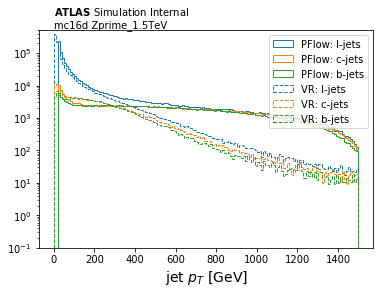

In [10]:
figDir = '../../figures/'

for physicsSample, jdfs, ptmax, ymax in zip(['ttbar','Zprime_1.5TeV'],
                                            [[jdf_PFlow_ttbar,jdf_VR_ttbar],[jdf_PFlow_Zprime,jdf_VR_Zprime]],
                                            [450,1500],[2e5,5e5]):

    print(physicsSample)
    plt.figure()
    
    for jet_df, jetCollection, l in zip(jdfs, ['PFlow','VR'], ['-','--']):

        for yi, (pdg,flav) in enumerate(zip([0,4,5],['l','c','b'])):
    
            plt.hist(jet_df.loc[jet_df.LabDr_HadF==pdg,'pt'], 
                     label='{}: {}-jets'.format(jetCollection,flav),
                     bins=150,range=(0,ptmax), color="C{}".format(yi), linestyle=l,
                     histtype='step',log=True)
    
    text="$\mathbf{ATLAS}$ Simulation Internal\n"
    text+="mc16d {}".format(physicsSample)
    
    plt.ylim(.1,ymax)
    plt.text(0,ymax,text,horizontalalignment='left', verticalalignment='bottom')
    plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
    plt.legend()
    plt.savefig('{}/mc16d_VR_{}/PFlow_cf/jet_pT.pdf'.format(figDir,physicsSample))

How many tracks do we have in the VR jets c.f. PFlow?

**Note:** The FTAG association radius depends on the jet $p_T$. Since the $p_T$ is lower for VR track jets, this means that we might expect the VR track jets to have more tracks getting fed to the RNN than the PFlow jets.

However, there are many other cuts that select the ip3d tracks, so I'm trying to understand how this gets propagated through to the inputs of my RNN.


In [11]:
X.shape

(1500000, 15, 13)

ttbar
Zprime_1.5TeV


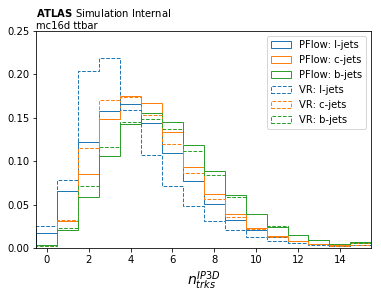

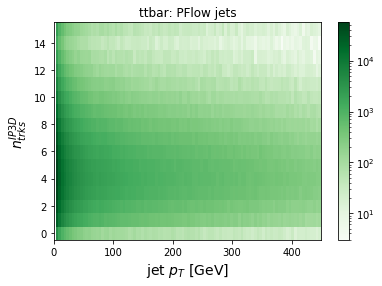

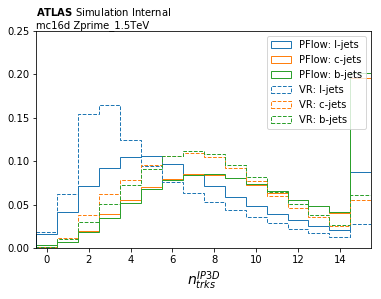

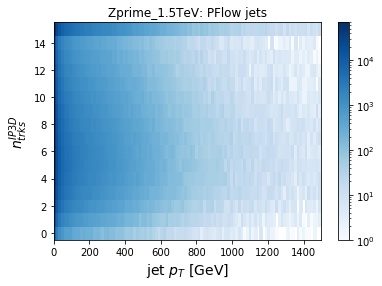

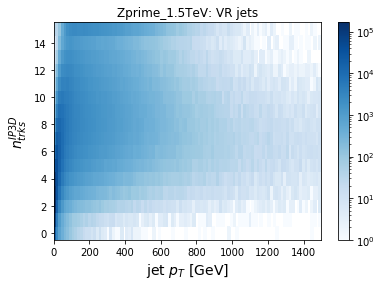

In [12]:
ylim = (0, 0.25)
xlim = (-0.5, 15.5)
for i,(physicsSample,Xs,ys,jdfs,ptmax,c,n) in enumerate(zip(['ttbar','Zprime_1.5TeV'],
                                                [[X_PFlow_ttbar,X_VR_ttbar],[X_PFlow_Zprime,X_VR_Zprime]],
                                                [[y_PFlow_ttbar,y_VR_ttbar],[y_PFlow_Zprime,y_VR_Zprime]],
                                                [[jdf_PFlow_ttbar,jdf_VR_ttbar],[jdf_PFlow_Zprime,jdf_VR_Zprime]],
                                                [450,1500],['Greens','Blues'],[45,50])):

    print(physicsSample)
    
    
    for j, X, y, jetCollection, l in zip(range(2),Xs, ys, ['PFlow','VR'], ['-','--']):
        
        # Caculate the number of tracks
        nTrks = np.sum(X.sum(axis=-1) != 0,axis=-1)
        plt.figure(i*3)
        for yi, flav in enumerate(['l','c','b']):
    
            plt.hist(nTrks[y==yi],  label='{}: {}-jets'.format(jetCollection,flav),
                     bins=16, range=xlim, color="C{}".format(yi), linestyle=l,
                     histtype='step',density=True)#,log=True)
        
        # I think it will also be useful to look at the ip3d tracks vs the jet pT
        plt.figure(i*3+j+1)
        plt.hist2d(jet_df.pt, nTrks, bins=(100,16), range=((0,ptmax),xlim), cmap=c,norm=LogNorm())
        plt.title('{}: {} jets'.format(physicsSample,jetCollection))
        plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
        plt.ylabel('$n_{trks}^{IP3D}$',fontsize=14)
        plt.colorbar()
        plt.savefig('{}/mc16d_{}_{}/ntrks_IP3D_vs_jet_pT.pdf'.format(figDir,jetCollection,physicsSample),
                    bbox_inches='tight')
    
    text="$\mathbf{ATLAS}$ Simulation Internal\n"
    text+="mc16d {}".format(physicsSample)
    
    plt.figure(i*3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.text(xlim[0],ylim[1],text,horizontalalignment='left', verticalalignment='bottom')
    plt.xlabel('$n_{trks}^{IP3D}$',fontsize=14)
    plt.legend()
    plt.savefig('{}/mc16d_VR_{}/PFlow_cf/ntrks_IP3D.pdf'.format(figDir,physicsSample),
                bbox_inches='tight')



Ok, it looks like the VR track jets on average have *less* tracks. This was surprising to me because the FTAG association cone is larger at low $p_T$.

But perhaps this could be due to the fact that since I have a much looser $p_T$ cut on the VR track jets, these crappier jets could be screwing up my conclusions. So I think I should plot this nTrks vs jet $p_T$ as well to see if this changes my conclusions at all!

## Step 2:  Extended hybrid eval

Ok, so the basic idea of this study is to ascertain the performance of the VR versus PFlow trainings.

However, this is **not** an apples to apples comparison, because there's no guarantee that we're using the same PFlow and VR track jets for testing, I really just wanted to get a first order comparison for how good VR track jets are doing on the training that I've already produced.

**Load in the model**

In [13]:
subDir = 'mc16d_PFlow_hybrid_5TeV'
dataTagTrain = "5mtrain_15trks_{}_sd0_rev".format(vStr)
nHidden=400

modelDir = '../../models/'+subDir
m = myLSTM(modelDir=modelDir, nFeatures=13, dataTag=dataTagTrain, nHidden=nHidden, loadModel=True)

Initialize method from myModel()
Loading previously trained LSTM


In [14]:
leffs, ceffs, beffs, discs = [],[],[],[]
physicsSamples = ['ttbar','Zprime_1.5TeV']

for i, (physicsSample, Xs, ys,ixs) in enumerate(zip(['ttbar','Zprime_1.5TeV'],
                                                [[X_PFlow_ttbar,X_VR_ttbar],[X_PFlow_Zprime,X_VR_Zprime]],
                                                [[y_PFlow_ttbar,y_VR_ttbar],[y_PFlow_Zprime,y_VR_Zprime]],
                                                [[ix_PFlow_ttbar,ix_VR_ttbar],[ix_PFlow_Zprime,ix_VR_Zprime]])):

    print(physicsSample)
    
    for X, y, ix, jetCollection, l, jetCollTag in zip(Xs, ys, ixs, ['PFlow','VR'], ['-','--'], ["","_VR"]):
    
        tag='_eval{}_{}'.format(jetCollTag,physicsSample)
        (leff, ceff, beff), disc = getEffs(m, X, y, ix, returnDisc=True, modelDir=m.modelDir,
                                           figDir=figDir, subDir=subDir,tag=tag)
        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        discs.append(disc)

ttbar
Load in the previously saved efficiency file
Load in the previously saved efficiency file
Zprime_1.5TeV
Load in the previously saved efficiency file
Load in the previously saved efficiency file


For the roc curves, I think it makes more sense to save them to the VR directory.

### Look at the $t\bar{t}$ comparison

In [15]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+="Train on mc16d PFlow extended hybrid sample"

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


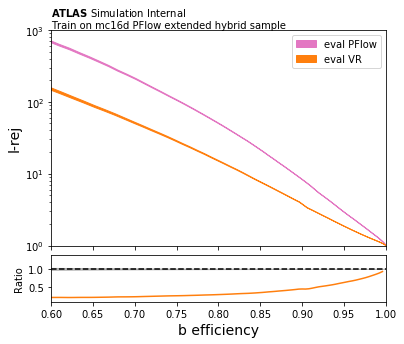

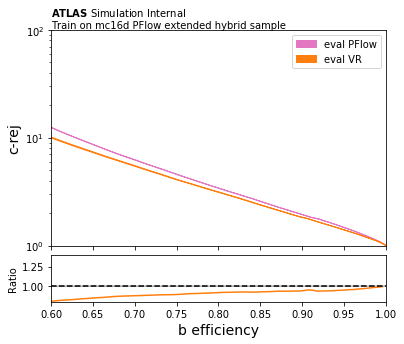

In [16]:
labels = ['eval PFlow','eval VR']
colors=['C6','C1']

subDir='mc16d_VR_ttbar'
tag='train_PFlow_ext_hybrid'
nTest_ttbar = [(y_VR_ttbar==yi).sum() for yi in range(3)]

plotROCRatio(beffs[:2], leffs[:2], labels, rrange=(0.1,1.4),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_'+tag)

plotROCRatio(beffs[:2], ceffs[:2], labels, rrange=(0.8,1.4),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_'+tag)

Ok, so I think the "drop" in performance that we're seeing is an artifact of the fact that since we're using looser VR track jet cuts, we're seeing a drop in the performance of the 

### Look at the Z' comparison

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


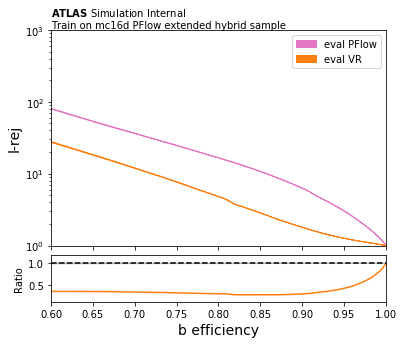

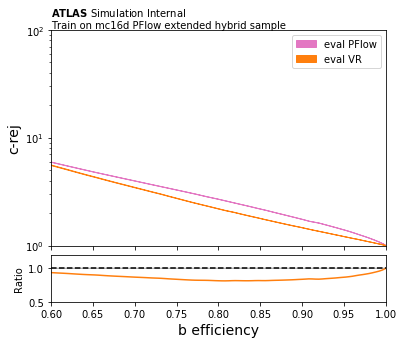

In [17]:
subDir='mc16d_VR_Zprime_1.5TeV'

nTest_Zprime = [(y_VR_Zprime==yi).sum() for yi in range(3)]

plotROCRatio(beffs[2:], leffs[2:], labels, rrange=(0.1,1.2),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,
             nTest=nTest_Zprime, colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_'+tag)

plotROCRatio(beffs[2:], ceffs[2:], labels, rrange=(0.5,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,
             nTest=nTest_Zprime, colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_'+tag)

Michael said this is just a domain adaptation problem, that will probably get sorted out once we retrain on the VR track jet collection. 

## Step 3: Compare the extended hybrid training with what is currently in the Ntuple

**Motivation:** Based on my studies in `VR-Selections`, it seems like this definition of the standard hybrid sample might need to be tweaked. We're also concerned with how alarmingly low the $p_T$ of the VR track jets are, and it seems like there are many issues that might need to be sorted out with these VR track jets that we might not be able to address in the timescope of this retraining campaign.

However, if I'm going to try to convince people to use my extended hybrid PFlow training for VR track jets as well, I'll need some kind of propaganda plot to motivate people that this is a good idea!

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


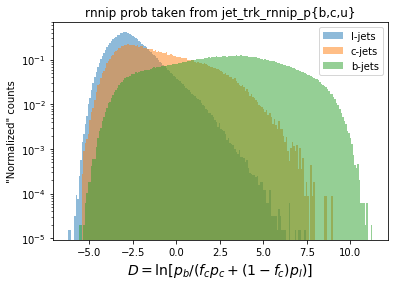

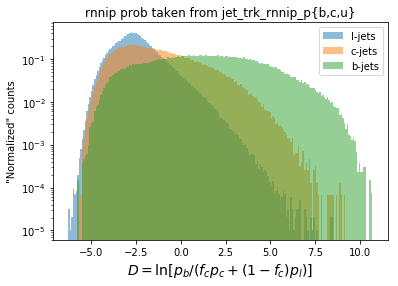

In [18]:
# Save the efficiencies from the previous training in a separate list
prev_leffs, prev_ceffs, prev_beffs, prev_discs = [], [], [], []
fc = 0.07
nBins = 200

for physicsSample in ['ttbar','Zprime_1.5TeV']:
    
    plt.figure()
        
    # Open the df
    dataDir = '../../data/mc16d_{}_{}'.format(jetCollection,physicsSample)
    df_tag = '2mtest_15trks_sd0_rev'
    jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

    disc = np.log(jet_df.rnnip_pb / (fc*jet_df.rnnip_pc + (1-fc)*jet_df.rnnip_pu))
    myRange = (disc.min(),disc.max())
    
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        n,_,_ = plt.hist(disc.loc[jet_df.LabDr_HadF == pdg],
                         bins=nBins,range=myRange, 
                         label="{}-jets".format(flav),
                         alpha = 0.5,
                         normed=True, log=True) 

        # Calculate the eff
        eff = calculateEff(n)

        if pdg == 0:
            prev_leffs.append(eff)
        elif pdg == 4:
            prev_ceffs.append(eff)
        elif pdg == 5:
            prev_beffs.append(eff)

    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('"Normalized" counts')
    plt.title("rnnip prob taken from jet_trk_rnnip_p{b,c,u}")
    plt.show()

../../plottingFcts.py:546: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


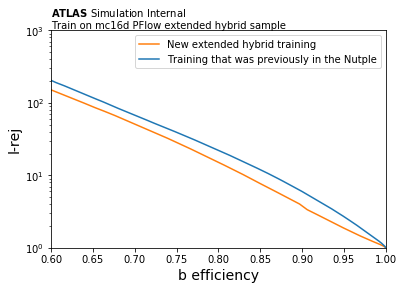

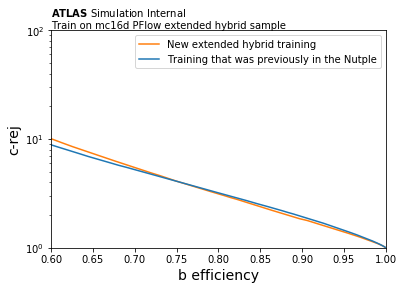

In [19]:
colors=['C1','C0']
labels=['New extended hybrid training',
        'Training that was previously in the Nutple']

subDir='mc16d_VR_ttbar'
tag='cf_Ntuple_train'

plotROC([beffs[1], prev_beffs[0]], [leffs[1],prev_leffs[0]], 
        labels, ymax=1000,
        text=text, ylabel='l-rej', colors=colors, 
        figDir=figDir, subDir=subDir, tag='lrej_'+tag)

plotROC([beffs[1],prev_beffs[0]], [ceffs[1],prev_ceffs[0]], 
        labels, ymax=100,
        text=text,ylabel='c-rej',colors=colors, 
        figDir=figDir,subDir=subDir,tag='crej_'+tag)


../../plottingFcts.py:546: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


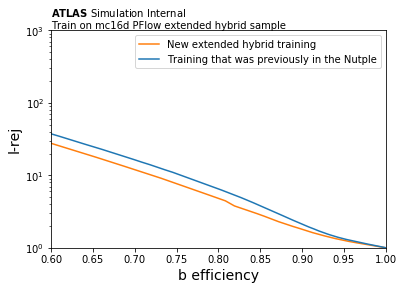

In [20]:
subDir='mc16d_VR_Zprime_1.5TeV'

plotROC([beffs[3], prev_beffs[1]], [leffs[3],prev_leffs[1]], 
        labels, ymax=1000,
        text=text, ylabel='l-rej', colors=colors, 
        figDir=figDir, subDir=subDir, tag='lrej_'+tag)

plotROC([beffs[3],prev_beffs[1]], [ceffs[3],prev_ceffs[1]], 
        labels, ymax=100,
        text=text,ylabel='c-rej',colors=colors, 
        figDir=figDir,subDir=subDir,tag='crej_'+tag)

## Step 4: Compare w/r.t. a dedicated retraining on a hybrid VR track jet sample

I wanted to use the same hyperparameters that worked for the standard hybrid, so this is a training on 4m jets with 200 hidden nodes.


Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


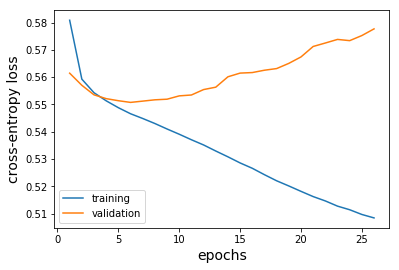

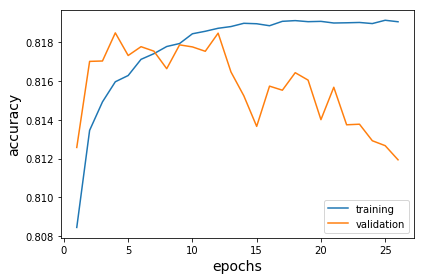

In [21]:
# Load in the model
subDir = 'mc16d_VR_hybrid_1.5TeV'
dataTagTrain = "4mtrain_15trks_{}_sd0_rev".format(vStr)
nHidden=200

modelDir = '../../models/'+subDir
m = myLSTM(modelDir=modelDir, nFeatures=13, dataTag=dataTagTrain, nHidden=nHidden, loadModel=True)

trainingMetrics(m.modelName,modelDir=modelDir)

Note, I can't use the same `X_VR_ttbar` and `X_VR_Zprime` input files from before, because I need to use the input samples that are scaled to the VR hybrid sample.

In [22]:
subDir

'mc16d_VR_hybrid_1.5TeV'

In [23]:
dataDir

'../../data/mc16d_VR_Zprime_1.5TeV'

In [24]:
VR_leffs, VR_ceffs, VR_beffs, VR_discs = [], [], [], []

dataDir = '../../data/'
scale_tag = '_hybrid_1.5TeV_scale'

for physicsSample in ['ttbar','Zprime_1.5TeV']:


    subDir = 'mc16d_VR_'+physicsSample
    f_name = "{}/data_{}{}.hdf5".format(dataDir+subDir,dataTagTest,scale_tag)

    f = h5py.File(f_name,"r")
    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]
    f.close()
    
    
    tag='_eval_{}'.format(physicsSample)
    (leff, ceff, beff), disc = getEffs(m, X, y, ix, returnDisc=True, modelDir=m.modelDir,
                                       figDir=figDir, subDir=subDir,tag=tag)
    VR_leffs.append(leff)
    VR_ceffs.append(ceff)
    VR_beffs.append(beff)
    
    VR_discs.append(disc)

Load in the previously saved efficiency file
Load in the previously saved efficiency file


### $t\bar{t}$ eval

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


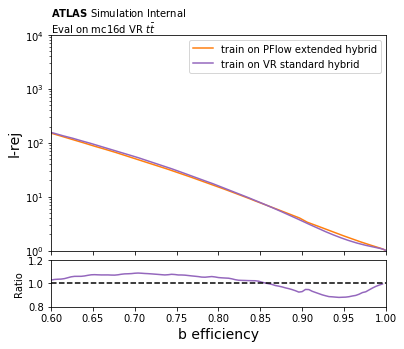

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


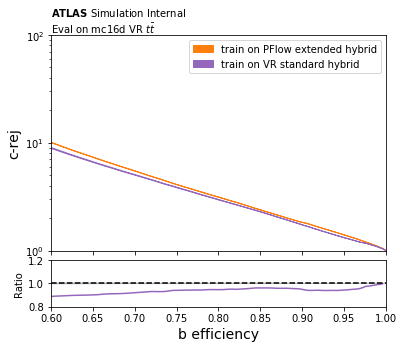

In [25]:
labels = ['train on PFlow extended hybrid','train on VR standard hybrid']
colors=['C1','C4']

subDir='mc16d_VR_ttbar'
tag='train_VR_hybrid'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

plotROCRatio([beffs[1], VR_beffs[0]], [leffs[1],VR_leffs[0]], 
             labels, rrange=(0.8,1.2),ymax=10000,
             text=text,ylabel='l-rej',binomialErrors=False,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_'+tag)

plotROCRatio([beffs[1],VR_beffs[0]], [ceffs[1],VR_ceffs[0]], 
             labels, rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_'+tag)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
../../plottingFcts.py:435: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff1[i] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:441: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff2[i*2] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:445: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff2[i*2+1] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:361: RuntimeWarning: invalid value encountered in true_divide
  effs[i][j] = num_mask.sum() / nTest[j]


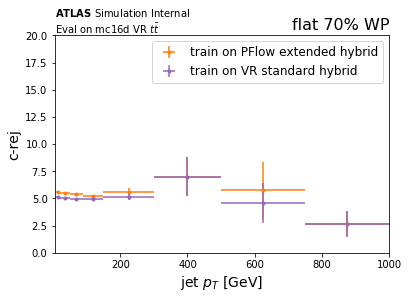

In [26]:
# Need to add discriminants to this notebook
plotPtDependence(jdf_VR_ttbar.pt.values,y_VR_ttbar,
                 [discs[1],VR_discs[0]], labels,
                 lrej_lim=(0,550),crej_lim=(0,20),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([5,10,20, 50, 90, 150, 300, 500, 750, 1000]),
                 eff_bins = np.array([5,7.5,10,15,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000]),
                 figDir=figDir,subDir=subDir,tag=tag,verbose=False)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
../../plottingFcts.py:435: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff1[i] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:441: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff2[i*2] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:445: RuntimeWarning: invalid value encountered in long_scalars
  sig_eff2[i*2+1] = num_mask.sum() / den_mask.sum()
../../plottingFcts.py:361: RuntimeWarning: invalid value encountered in true_divide
  effs[i][j] = num_mask.sum() / nTest[j]
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


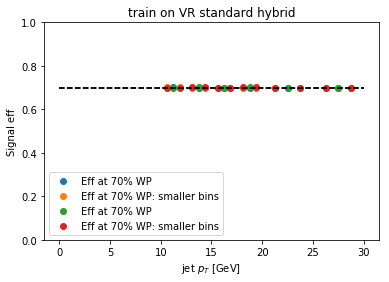

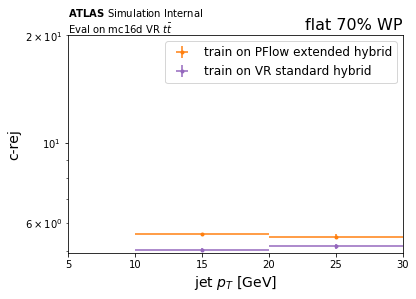

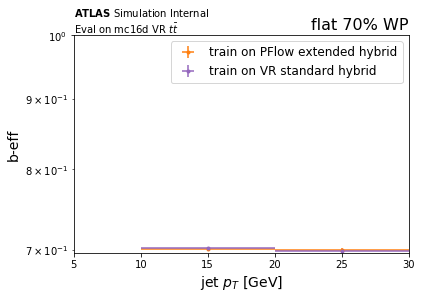

In [27]:
plotPtDependence(jdf_VR_ttbar.pt.values,y_VR_ttbar,
                 [discs[1],VR_discs[0]], labels,log=True,
                 lrej_lim=(0,200),crej_lim=(0,20),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([5, 7, 10, 20, 30]),
                 eff_bins = np.array([5,6,7,8,9,10,12.5,15,17.5,20,25,30]),
                 figDir=figDir,subDir=subDir,tag=tag+"_low_pt",
                 verbose=False)

### Z' eval

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


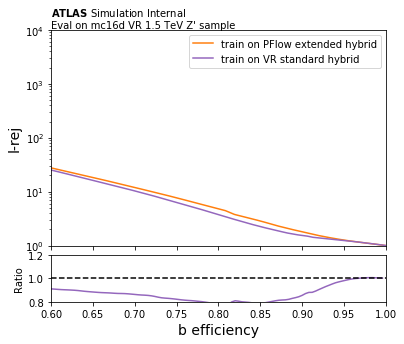

../../plottingFcts.py:595: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


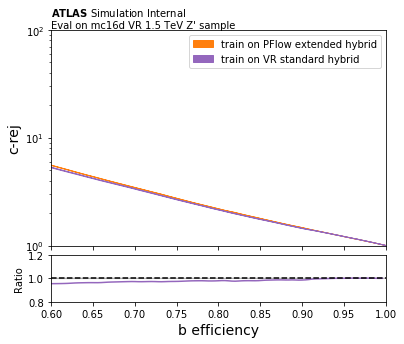

In [28]:
labels = ['train on PFlow extended hybrid','train on VR standard hybrid']
colors=['C1','C4']

subDir='mc16d_VR_Zprime_1.5TeV'
tag='train_VR_hybrid'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR 1.5 TeV Z' sample"

plotROCRatio([beffs[3], VR_beffs[1]], [leffs[3],VR_leffs[1]], 
             labels, rrange=(0.8,1.2),ymax=10000,
             text=text,ylabel='l-rej',binomialErrors=False,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_'+tag)

plotROCRatio([beffs[3],VR_beffs[1]], [ceffs[3],VR_ceffs[1]], 
             labels, rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,
             nTest=nTest_ttbar, colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_'+tag)

**Next:** Look at the $p_T$ dependence of these plots.

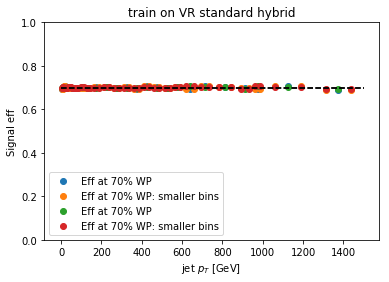

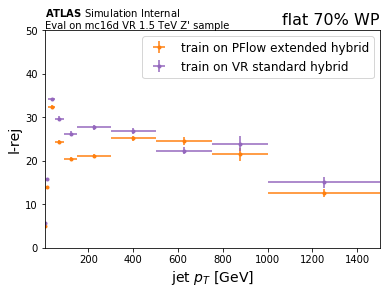

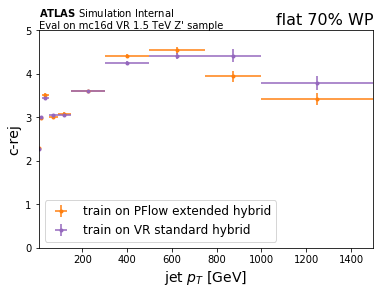

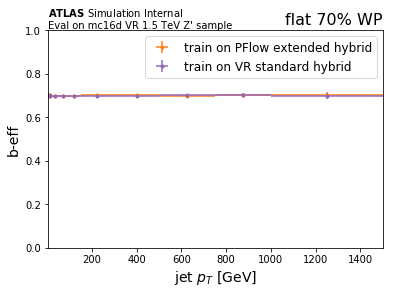

In [29]:
plotPtDependence(jdf_VR_Zprime.pt.values,y_VR_Zprime,
                 [discs[3],VR_discs[1]], labels,
                 lrej_lim=(0,50),crej_lim=(0,5),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([5,10,20, 50, 90, 150, 300, 500, 750, 1000,1500]),
                 eff_bins = np.array([5,7.5,10,15,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000,1250,1500]),
                 figDir=figDir,subDir=subDir,tag=tag,verbose=False)

I guess the message of the $p_T$ plots is that the models are not wildly different, and the dedicated VR retraining does seem to have some performance gains at low $p_T$. But, I'm not sure if these plots make sense with the overall roc curves.